# Damage detection MLP that monitors folder Inspect and runs automatically
I am using Python because I am most comfortable writing ML code in it.  I want to learn Cython so that I can take advantage of C's speed advantage where it is necessary.  

So this problem is classification into 50 categories, ie. 2 types of defect * (5 * 5 grid) = 50.  The sample size of 150 is quite small so I used elastic transformation algorithm in the other ipynb notebook called "ElasticTransform.ipynb".  Elastic transformation is done on medical imagery which is also overlayed on grids so is appropriate here.  Applying three different transformations on the entire data set gave me an additional 450 images for a total of 600.  

I should have tried transfer learning first but I tried MLP (2.5% accuracy), then my own CNN (5% accuracy) and finally Transfer Learning (30% accuracy).  The image augmentation explained above boosted VGG16 transfer learning (Model 2 not Model 1) to 95% on the first try.  I was surprised because my training loss was higher than validation loss.  I learned a valuable lesson on this assignment and that is "never reinvent the wheel."

Click on the link to skip to transfer learning.  There is no need to run any cells before transfer learning.
[Link to Transfer Learning](#the_destination)

# Read in and preprocess images 
First read them in using cv2 methods and then rescale RGB to range within [0,1]

<class 'list'>




unsorted


 ['DataSet/Image/1.png', 'DataSet/Image/10.png', 'DataSet/Image/100.png', 'DataSet/Image/101.png', 'DataSet/Image/102.png', 'DataSet/Image/103.png', 'DataSet/Image/104.png', 'DataSet/Image/105.png', 'DataSet/Image/106.png', 'DataSet/Image/107.png', 'DataSet/Image/108.png', 'DataSet/Image/109.png', 'DataSet/Image/11.png', 'DataSet/Image/110.png', 'DataSet/Image/111.png', 'DataSet/Image/112.png', 'DataSet/Image/113.png', 'DataSet/Image/114.png', 'DataSet/Image/115.png', 'DataSet/Image/116.png', 'DataSet/Image/118.png', 'DataSet/Image/119.png', 'DataSet/Image/12.png', 'DataSet/Image/120.png', 'DataSet/Image/121.png', 'DataSet/Image/122.png', 'DataSet/Image/123.png', 'DataSet/Image/124.png', 'DataSet/Image/125.png', 'DataSet/Image/126.png', 'DataSet/Image/127.png', 'DataSet/Image/128.png', 'DataSet/Image/129.png', 'DataSet/Image/13.png', 'DataSet/Image/130.png', 'DataSet/Image/131.png', 'DataSet/Image/132.png', 'DataSet/Image/133.png', 'DataSet/Image/134.png',

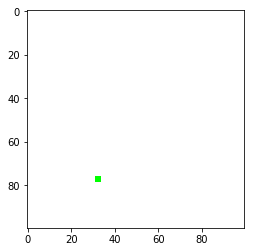

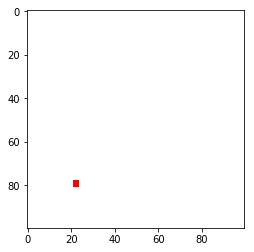

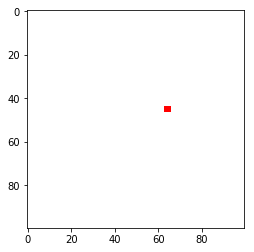

In [5]:
%matplotlib inline
#read in 100 by 100 pixel images 
import os
import cv2
import numpy as np
import sys
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from natsort import natsorted
#np.set_printoptions(threshold=sys.maxsize)

filenames = [img for img in glob.glob("DataSet/Image/*.png")]

filenames = natsorted(filenames)

images = [cv2.imread(img) for img in filenames]

#check that we have 150 images
print("len images ", len(images))

#convert from BGR to RGB 
for img in images:
    img[np.where((img == [0, 0, 255]).all(axis=2))] = [255, 0, 0]

#plot first 3 images in dataset
for i in range(3):
    plt.imshow(images[i])
    plt.show()



150
600


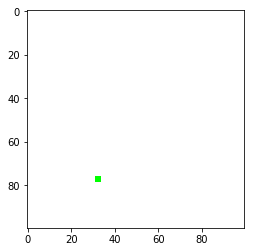

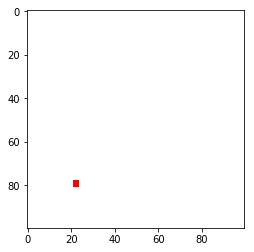

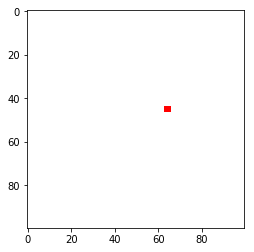

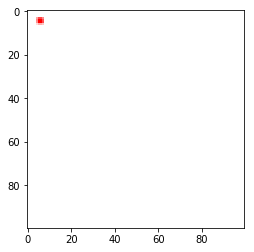

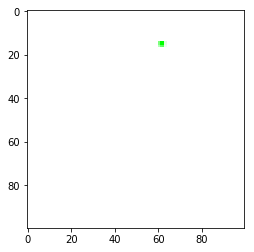

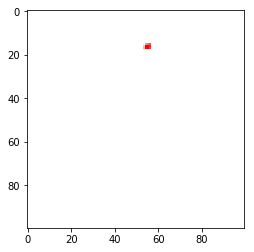

In [30]:
"""Load distorted.npy which are the elastic transformations and combine data sets to make one big data set of
600 images"""
import numpy as np
distorted1 = np.load("DataSet/AugImages/distorted1/distorted1.npy")
distorted2 = np.load("DataSet/AugImages/distorted2/distorted2.npy")
distorted3 = np.load("DataSet/AugImages/distorted3/distorted3.npy")


images = np.array(images)

combined_data = np.concatenate((images, distorted1, distorted2, distorted3), axis=0)

#check for 600
print(len(combined_data))

#plot and check first and last 3 images
for i in range(3):
    plt.imshow(combined_data[i])
    plt.show()
for i in range(3):    
    plt.imshow(combined_data[-i-1])
    plt.show()



In [15]:
"""
SKIP THIS CELL 

#divide into training and test sets
x_train = images[:100]
x_valid = images[100:130]
x_test = images[130:]
x_train = np.array(x_train)
x_valid = np.array(x_valid)
x_test = np.array(x_test)

#rescale
x_train = x_train/255.0
x_valid = x_valid/255.0
x_test = x_test/255.0

print("train\n\n", x_train[1]) #matrix of 100 * 100 * 3
print("test\n\n", x_test[1])
"""

'\n#divide into training and test sets\nx_train = images[:100]\nx_valid = images[100:130]\nx_test = images[130:]\nx_train = np.array(x_train)\nx_valid = np.array(x_valid)\nx_test = np.array(x_test)\n\n#rescale\nx_train = x_train/255.0\nx_valid = x_valid/255.0\nx_test = x_test/255.0\n\nprint("train\n\n", x_train[1]) #matrix of 100 * 100 * 3\nprint("test\n\n", x_test[1])\n'

# Create labels for data in csv file for 1.png to 150.png

In [17]:
#create Pandas dataframe from csv to make labels for the images
import pandas as pd

labels_df = pd.read_csv('DataSet/data.csv')

#clean whitespaces
labels_df['FileName'].str.strip()
labels_df[' DefectLocation'].str.strip()
labels_df[' Cause'].str.strip()

#slice the FileName column
df1 = labels_df[['FileName']]

#slice the location and cause cols to create target labels
df2 = labels_df[[' DefectLocation', ' Cause']]
location = df2[' DefectLocation'].tolist()
cause = df2[' Cause'].tolist()

#make the labels here as a list of tuples
data_labels = []
for i in range(len(location)):
    tupleObj = (location[i], cause[i])
    data_labels.append(tupleObj)
print("\n\n\ndata_labels\n", data_labels)
print("len data_labels", len(data_labels))


['FileName', ' DefectLocation', ' Cause']
    FileName  DefectLocation     Cause
0      1.png              B4   Scratch
1      2.png              B4     Crack
2      3.png              D3     Crack
3      4.png              D5     Crack
4      5.png              E4   Scratch
5      6.png              B2     Crack
6      7.png              c5     Crack
7      8.png              E2   Scratch
8      9.png              D3   Scratch
9     10.png              B2   Scratch
10    11.png              E4     Crack
11    12.png              D1   Scratch
12    13.png              c2   Scratch
13    14.png              D4     Crack
14    15.png              c2   Scratch
15    16.png              B3     Crack
16    17.png              A1     Crack
17    18.png              E5   Scratch
18    19.png              B3     Crack
19    20.png              A2   Scratch
20    21.png              c2   Scratch
21    22.png              E4   Scratch
22    23.png              D1   Scratch
23    24.png          

# One hot encode the labels 
Form a vector of 50 elements, 0 to 24 are A1 to E5 for cracks and 25 to 49 are A1 to E5 for scratches
First form tuples and then let the tuples be one hot encoded.
Let cracks = 0, scratch = 1 and form tuples, ie. (1,1) would be (A1, scratch)




In [18]:
#note spacing in strings per training data
location = [' A1', ' A2', ' A3', ' A4', ' A5', ' B1', ' B2', ' B3', ' B4', ' B5', ' c1', ' c2', ' c3', ' c4', ' c5', ' D1', \
            ' D2', ' D3', ' D4', ' D5', ' E1', ' E2', ' E3', ' E4', ' E5']

cause1, cause2 = ' Crack', ' Scratch'

cracks, scratches = [], []

#create lists of tuples
for i in range(len(location)):
    tupleObj = (location[i], cause1)
    cracks.append(tupleObj)
    
for i in range(len(location)):
    tupleObj = (location[i], cause2)
    scratches.append(tupleObj)

#concatenate
labels = cracks + scratches
print(labels)
#index of each element will act as the integer label for one hot encoding
print(len(labels)) #50




[(' A1', ' Crack'), (' A2', ' Crack'), (' A3', ' Crack'), (' A4', ' Crack'), (' A5', ' Crack'), (' B1', ' Crack'), (' B2', ' Crack'), (' B3', ' Crack'), (' B4', ' Crack'), (' B5', ' Crack'), (' c1', ' Crack'), (' c2', ' Crack'), (' c3', ' Crack'), (' c4', ' Crack'), (' c5', ' Crack'), (' D1', ' Crack'), (' D2', ' Crack'), (' D3', ' Crack'), (' D4', ' Crack'), (' D5', ' Crack'), (' E1', ' Crack'), (' E2', ' Crack'), (' E3', ' Crack'), (' E4', ' Crack'), (' E5', ' Crack'), (' A1', ' Scratch'), (' A2', ' Scratch'), (' A3', ' Scratch'), (' A4', ' Scratch'), (' A5', ' Scratch'), (' B1', ' Scratch'), (' B2', ' Scratch'), (' B3', ' Scratch'), (' B4', ' Scratch'), (' B5', ' Scratch'), (' c1', ' Scratch'), (' c2', ' Scratch'), (' c3', ' Scratch'), (' c4', ' Scratch'), (' c5', ' Scratch'), (' D1', ' Scratch'), (' D2', ' Scratch'), (' D3', ' Scratch'), (' D4', ' Scratch'), (' D5', ' Scratch'), (' E1', ' Scratch'), (' E2', ' Scratch'), (' E3', ' Scratch'), (' E4', ' Scratch'), (' E5', ' Scratch')]

In [19]:
"""create labels for the train images by iterating through list and looking for matching tuples of 
location & damage type"""
train_labels = []
train_labels_ints = []
missing =[]
for i in range(len(data_labels)): #len 150
    for j in range(len(labels)): #len 50
        if data_labels[i] == labels[j]: 
            tupleObj = (j, data_labels[i])
            train_labels.append(tupleObj) #just want the index
            train_labels_ints.append(j)

#had problems finding C1 because of spacing error...
for i in range(len(data_labels)):
    if data_labels[i] not in labels:
        tupleObj2 = (i, data_labels[i])
        missing.append(tupleObj2)
print("\n\nmissing\n", missing)
print("\n\ntrain_labels \n", train_labels)
print("\n\ntrain_labels_ints\n", train_labels_ints)
print("len train labels ", len(train_labels))
print("len train_labels_ints", len(train_labels_ints))



missing
 []


train_labels 
 [(33, (' B4', ' Scratch')), (8, (' B4', ' Crack')), (17, (' D3', ' Crack')), (19, (' D5', ' Crack')), (48, (' E4', ' Scratch')), (6, (' B2', ' Crack')), (14, (' c5', ' Crack')), (46, (' E2', ' Scratch')), (42, (' D3', ' Scratch')), (31, (' B2', ' Scratch')), (23, (' E4', ' Crack')), (40, (' D1', ' Scratch')), (36, (' c2', ' Scratch')), (18, (' D4', ' Crack')), (36, (' c2', ' Scratch')), (7, (' B3', ' Crack')), (0, (' A1', ' Crack')), (49, (' E5', ' Scratch')), (7, (' B3', ' Crack')), (26, (' A2', ' Scratch')), (36, (' c2', ' Scratch')), (48, (' E4', ' Scratch')), (40, (' D1', ' Scratch')), (17, (' D3', ' Crack')), (28, (' A4', ' Scratch')), (41, (' D2', ' Scratch')), (12, (' c3', ' Crack')), (35, (' c1', ' Scratch')), (39, (' c5', ' Scratch')), (22, (' E3', ' Crack')), (22, (' E3', ' Crack')), (11, (' c2', ' Crack')), (33, (' B4', ' Scratch')), (13, (' c4', ' Crack')), (27, (' A3', ' Scratch')), (29, (' A5', ' Scratch')), (33, (' B4', ' Scratch')), (37, (

In [57]:
#one hot encode them
from keras.utils import np_utils

labels_hot = []
hot_labels = []
for i in range(len(labels)):
    hot_label = np_utils.to_categorical(i, 50)
    hot_labels.append(hot_label)
    tupleObj = (hot_label, labels[i])
    labels_hot.append(tupleObj)
    
#check the first ten one hot labels
print(labels_hot[:3]) #tuple version for reference
print(hot_labels[:3]) #one-hot only

#now one-hot encode training data:
train_hots = []
for i in range(len(train_labels_ints)):
    train_hot = np_utils.to_categorical(train_labels_ints[i], 50)
    train_hots.append(train_hot)


#need one-hot encodings for the elastic transformation data augmentation 
onehot_distort1 = train_hots #150 
onehot_distort2 = train_hots #150
onehot_distort3 = train_hots #150

combined_onehot = np.concatenate((train_hots, onehot_distort1, onehot_distort2, onehot_distort3), axis=0 )

print(len(combined_onehot))

"""
#for MLP
y_train = train_hots[:100]
y_train = np.array(y_train)
y_valid = train_hots[100:130]
y_valid = np.array(y_valid)
y_test = train_hots[130:]
y_test = np.array(y_test)

print("y_train1\n\n", y_train[1])
print("y_test1\n\n", y_test[1])
"""
print("type of labels_hot and hot_labels\n\n", type(labels_hot), type(hot_labels))   

[(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), (' A1', ' Crack')), (array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), (' A2', ' Crack')), (array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), (' A3', ' Crack'))]
[array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 

In [35]:
#shuffle and divide into train, valid and test 
from sklearn.utils import shuffle
import numpy as np

combined_data, combined_onehot = shuffle(combined_data, combined_onehot)

print(len(combined_data), len(combined_onehot))

#divided based on formula to use 80% for training and 80/20 split of training data for train/validation
x_train = combined_data[:380]
x_valid = combined_data[380:480]
x_test = combined_data[480:]

y_train = combined_onehot[:380]
y_valid = combined_onehot[380:480]
y_test = combined_onehot[480:]

"""
#test
for i in range(3):
    plt.imshow(combined_data[i])
    plt.show()
    print(combined_onehot[i])
for i in range(3):    
    plt.imshow(combined_data[-i-1])
    plt.show()
    print(combined_onehot[-i-1])
"""



600 600


'\n#test\nfor i in range(3):\n    plt.imshow(combined_data[i])\n    plt.show()\n    print(combined_onehot[i])\nfor i in range(3):    \n    plt.imshow(combined_data[-i-1])\n    plt.show()\n    print(combined_onehot[-i-1])\n'

In [41]:
"""save to disk for upload to Colab
save new image dataset 
"""
import os
import cv2
import numpy as np

mypath = "DataSet/DataAndLabels"
if not os.path.isdir(mypath):
    os.makedirs(mypath)

#save numpy arrays
from tempfile import TemporaryFile

np.save(os.path.join('DataSet/DataAndLabels', 'x_train'), x_train)
np.save(os.path.join('DataSet/DataAndLabels', 'x_valid'), x_valid)
np.save(os.path.join('DataSet/DataAndLabels', 'x_test'), x_test)
np.save(os.path.join('DataSet/DataAndLabels', 'y_train'), y_train)
np.save(os.path.join('DataSet/DataAndLabels', 'y_valid'), y_valid)
np.save(os.path.join('DataSet/DataAndLabels', 'y_test'), y_test)








# Build the MLP
This part was useless..

In [36]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Activation, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
from keras.regularizers import l1

#instantiate regularizer
reg = l1(0.001)

#2 type of damage * 25 zones = 50
num_output_nodes = len(labels)
print("lenlabels", len(labels))

#define the model
model = Sequential()
model.add(Flatten(input_shape=x_train.shape[1:])) # (100, 100, 3) 
model.add(Dense(1024, activation='linear', activity_regularizer=l1(0.001)))#512, 1024, 2048, 4096
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5)) #increase if overfitting
model.add(Dense(512, activation='linear', activity_regularizer=l1(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_output_nodes, activation='softmax'))
          
model.summary()
#compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


lenlabels 50
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              30721024  
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
____________________________________________________________

In [37]:
#evaluate test accuracy
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

#print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 1.6667%


# Train the Model

In [38]:
from keras.callbacks import ModelCheckpoint

#train the model
checkpointer = ModelCheckpoint(filepath='detector.model.best.hdf5', verbose=1, save_best_only=True)

hist = model.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_valid, y_valid), callbacks=[checkpointer], \
                verbose=1, shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 380 samples, validate on 100 samples
Epoch 1/100
380/380 [==============================] - 11s 30ms/step - loss: 165594.5594 - acc: 0.0079 - val_loss: 93085.7129 - val_acc: 0.0200
Epoch 2/100
380/380 [==============================] - 10s 27ms/step - loss: 75838.1614 - acc: 0.0132 - val_loss: 49512.1837 - val_acc: 0.0400
Epoch 3/100
380/380 [==============================] - 10s 28ms/step - loss: 45578.3491 - acc: 0.0237 - val_loss: 35866.9306 - val_acc: 0.0100
Epoch 4/100
380/380 [==============================] - 10s 28ms/step - loss: 36280.3790 - acc: 0.0184 - val_loss: 29810.8448 - val_acc: 0.0100
Epoch 5/100
380/380 [==============================] - 11s 29ms/step - loss: 32202.2462 - acc: 0.0105 - val_loss: 28294.9008 - val_acc: 0.0000e+00
Epoch 6/100
380/380 [==============================] - 7s 18ms/step - loss: 31536.3221 - acc: 0.0263 - val_loss: 29421.3645 - val_acc: 0.0000e+00
Epoch 7/100
380/380 [===================

Epoch 28/100
380/380 [==============================] - 19s 51ms/step - loss: 28839.8001 - acc: 0.0105 - val_loss: 27192.4911 - val_acc: 0.0300
Epoch 29/100
380/380 [==============================] - 20s 53ms/step - loss: 28813.3459 - acc: 0.0184 - val_loss: 26272.8370 - val_acc: 0.0100
Epoch 30/100
380/380 [==============================] - 18s 47ms/step - loss: 28716.2426 - acc: 0.0184 - val_loss: 27272.0806 - val_acc: 0.0100
Epoch 31/100
380/380 [==============================] - 17s 46ms/step - loss: 28578.5620 - acc: 0.0263 - val_loss: 26500.7607 - val_acc: 0.0200
Epoch 32/100
380/380 [==============================] - 28s 73ms/step - loss: 28039.8424 - acc: 0.0158 - val_loss: 25635.5952 - val_acc: 0.0300
Epoch 33/100
380/380 [==============================] - 18s 46ms/step - loss: 28085.5845 - acc: 0.0263 - val_loss: 26373.0210 - val_acc: 0.0300
Epoch 34/100
380/380 [==============================] - 20s 51ms/step - loss: 28022.9646 - acc: 0.0132 - val_loss: 26423.3524 - val_acc:

380/380 [==============================] - 17s 44ms/step - loss: 27668.7559 - acc: 0.0237 - val_loss: 26344.5450 - val_acc: 0.0100
Epoch 59/100
380/380 [==============================] - 17s 46ms/step - loss: 27600.6408 - acc: 0.0316 - val_loss: 26846.6419 - val_acc: 0.0100
Epoch 60/100
380/380 [==============================] - 18s 48ms/step - loss: 27636.5092 - acc: 0.0263 - val_loss: 26466.6896 - val_acc: 0.0100
Epoch 61/100
380/380 [==============================] - 18s 46ms/step - loss: 27443.6165 - acc: 0.0342 - val_loss: 25602.1697 - val_acc: 0.0000e+00
Epoch 62/100
380/380 [==============================] - 17s 44ms/step - loss: 27216.2314 - acc: 0.0237 - val_loss: 25913.8676 - val_acc: 0.0300
Epoch 63/100
380/380 [==============================] - 16s 42ms/step - loss: 27301.0288 - acc: 0.0184 - val_loss: 25803.6204 - val_acc: 0.0500
Epoch 64/100
380/380 [==============================] - 16s 42ms/step - loss: 27499.7123 - acc: 0.0289 - val_loss: 27003.3814 - val_acc: 0.0300
E

KeyboardInterrupt: 

### Load the Model with the Best Validation Loss

In [39]:
model.load_weights('detector.model.best.hdf5')

# Calculate the classification accuracy on the test set

In [40]:
#evaluate test accuracy
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

#print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

120/120 [==============================] - 1s 4ms/step
Test accuracy: 2.5000%


# Conclusion:  
Should have tried CNN transfer learning first...

# Keras CNN
This was also pretty bad...

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  


$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

# Data Pre-processing

Can skip this section as it was before the transfer learning.

In [15]:
#check len of datasets
print(len(x_train))
print(len(x_valid))
print(len(x_test))
print(len(y_train))
print(len(y_valid))
print(len(y_test))

100
30
20
100
30
20


In [74]:
"""
#divide into train, valid and test for CNN
x_valid = x_train[100:] #30 samples
x_train = x_train[:100]
x_test = x_test

print(len(x_valid), len(x_train))
y_valid = y_train[100:] 
y_train = y_train[:100]
y_test = y_test
"""

#reshape
x_train = x_train.reshape(100, 100, 100, 3)
x_valid = x_valid.reshape(30, 100, 100, 3)
x_test = x_test.reshape(20, 100, 100, 3)




In [153]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D 
from keras.layers import Flatten, Dense, BatchNormalization, Dropout


model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, padding='valid', activation='relu', \
                 input_shape=(100,100,3))) #none means any (nb_samples, rows, cols, channels)
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.7))

model.add(Conv2D(filters=32, kernel_size=3, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.7))

model.add(Conv2D(filters=32, kernel_size=3, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.7))

model.add(Conv2D(filters=64, kernel_size=3, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.7))

model.add(Conv2D(filters=64, kernel_size=3, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.7))
#model.add(GlobalAveragePooling2D())
#model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.7))
model.add(Dense(len(labels), activation='softmax')) #50 output nodes

model.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 98, 98, 16)        448       
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 49, 49, 16)        0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 47, 47, 32)        4640      
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 21, 21, 32)        9248      
__________

# Compile the Model

In [154]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'] )

In [155]:
from keras.callbacks import ModelCheckpoint

epochs = 100
batch_size= 32

filepath="weights.best.from_scratch_cnn.hdf5"

checkpointer = ModelCheckpoint(filepath=filepath, verbose=1, save_best_only=True)

model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=epochs, batch_size=batch_size, \
         callbacks=[checkpointer], verbose=1)

ValueError: Error when checking target: expected dense_53 to have 4 dimensions, but got array with shape (100, 50)

# Load Model with Best Validation Loss

In [144]:
model.load_weights('weights.best.from_scratch_cnn.hdf5') 

# Evaluate the model

In [145]:
scores = model.evaluate(x_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

20/20 [==============================] - 0s 7ms/step
Accuracy: 0.00%


# Test the Model 
I am pretty sure I need to use image augmentation and maybe transfer learning from Resnet50 or VGG 16, etc to get 80% accuracy

In [146]:
#get index of predicted zone and type of damage for each image in test set
predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in x_test]

#report test accuracy
test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(y_test, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 0.0000%


# Create and Configure Augmented Image Generator

In [82]:
from keras.preprocessing.image import ImageDataGenerator

#create and configure augmented image generator
datagen_train = ImageDataGenerator(width_shift_range=-0.1, height_shift_range=-0.1, horizontal_flip=True, \
                                  vertical_flip=True)

#fit augmented image generator on data
datagen_train.fit(x_train)

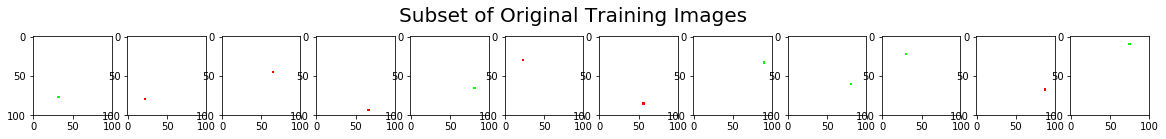

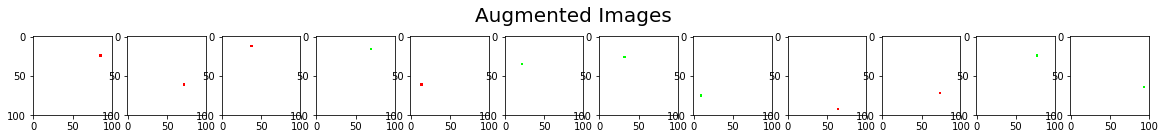

In [83]:
# Visualize 
import matplotlib.pyplot as plt

# take subset of training data
x_train_subset = x_train[:12]

# visualize subset of training data
fig = plt.figure(figsize=(20,2))
for i in range(0, len(x_train_subset)):
    ax = fig.add_subplot(1, 12, i+1)
    ax.imshow(x_train_subset[i])
fig.suptitle('Subset of Original Training Images', fontsize=20)
plt.show()

# visualize augmented images
fig = plt.figure(figsize=(20,2))
for x_batch in datagen_train.flow(x_train_subset, batch_size=12):
    for i in range(0, 12):
        ax = fig.add_subplot(1, 12, i+1)
        ax.imshow(x_batch[i])
    fig.suptitle('Augmented Images', fontsize=20)
    plt.show()
    break;

In [84]:
#train the CNN again
from keras.callbacks import ModelCheckpoint

batch_size = 32
epochs = 100

#train the model
checkpointer = ModelCheckpoint(filepath='augment_model.weights.best.hdf5', verbose=1, save_best_only=True)
model.fit_generator(datagen_train.flow(x_train, y_train, batch_size=batch_size), steps_per_epoch=x_train.shape[0] \
                   // batch_size, epochs=epochs, verbose=2, callbacks=[checkpointer], \
                   validation_data=(x_valid, y_valid), validation_steps=x_valid.shape[0] // batch_size)

Epoch 1/100
Epoch 00001: val_loss improved from inf to 3.25434, saving model to augment_model.weights.best.hdf5
 - 11s - loss: 6.0189 - acc: 0.1466 - val_loss: 3.2543 - val_acc: 0.3667
Epoch 2/100
Epoch 00002: val_loss did not improve
 - 9s - loss: 6.5908 - acc: 0.0833 - val_loss: 3.4953 - val_acc: 0.2333
Epoch 3/100
Epoch 00003: val_loss did not improve
 - 7s - loss: 5.1302 - acc: 0.1494 - val_loss: 3.8305 - val_acc: 0.1000
Epoch 4/100
Epoch 00004: val_loss did not improve
 - 7s - loss: 3.7500 - acc: 0.1581 - val_loss: 4.0000 - val_acc: 0.0000e+00
Epoch 5/100
Epoch 00005: val_loss did not improve
 - 7s - loss: 3.6962 - acc: 0.1149 - val_loss: 4.0267 - val_acc: 0.1000
Epoch 6/100
Epoch 00006: val_loss did not improve
 - 7s - loss: 3.5809 - acc: 0.0919 - val_loss: 4.0383 - val_acc: 0.1000
Epoch 7/100
Epoch 00007: val_loss did not improve
 - 9s - loss: 3.6716 - acc: 0.1146 - val_loss: 4.0446 - val_acc: 0.1000
Epoch 8/100
Epoch 00008: val_loss did not improve
 - 7s - loss: 3.6143 - acc: 0

Epoch 00067: val_loss did not improve
 - 10s - loss: 2.2538 - acc: 0.3958 - val_loss: 4.7548 - val_acc: 0.1000
Epoch 68/100
Epoch 00068: val_loss did not improve
 - 7s - loss: 2.2688 - acc: 0.3736 - val_loss: 3.5956 - val_acc: 0.2333
Epoch 69/100
Epoch 00069: val_loss did not improve
 - 8s - loss: 2.4291 - acc: 0.3304 - val_loss: 3.7180 - val_acc: 0.2333
Epoch 70/100
Epoch 00070: val_loss did not improve
 - 7s - loss: 2.6336 - acc: 0.2528 - val_loss: 4.0114 - val_acc: 0.0667
Epoch 71/100
Epoch 00071: val_loss did not improve
 - 9s - loss: 2.5227 - acc: 0.3021 - val_loss: 4.2885 - val_acc: 0.1333
Epoch 72/100
Epoch 00072: val_loss did not improve
 - 7s - loss: 2.5353 - acc: 0.2068 - val_loss: 4.2945 - val_acc: 0.1333
Epoch 73/100
Epoch 00073: val_loss did not improve
 - 8s - loss: 2.6049 - acc: 0.2270 - val_loss: 4.0722 - val_acc: 0.1667
Epoch 74/100
Epoch 00074: val_loss did not improve
 - 8s - loss: 2.5535 - acc: 0.3074 - val_loss: 3.9159 - val_acc: 0.1667
Epoch 75/100
Epoch 00075: va

In [85]:
#load model with best accuracy
model.load_weights('augment_model.weights.best.hdf5')

In [86]:
#evaluate and print accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.3499999940395355


# Disappointing results:

I am guessing that because it is not the same as shifting, flipping vertically/horizontally a picture of a cat or dog, ie. the location of the dot is what ties it to its label, this type of image augmentation has very little benefit.  

# Transfer Learning

### 1. Load and Preprocess Sample Images

Before supplying an image to a pre-trained network in Keras, there are some required preprocessing steps.  
You will learn more about this in the project; for now, we have implemented this functionality for you in the 
first code cell of the notebook.  We have imported a very small dataset of 8 images and stored the  preprocessed image input as `img_input`.  Note that the dimensionality of this array is `(8, 224, 224, 3)`.  In this case, each of the 8 images is a 3D tensor, with shape `(224, 224, 3)`.

In [110]:
#skip this cell since we already have bottleneck features
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
import numpy as np
import glob

img_paths = glob.glob("DataSet/Image/*.png")

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in img_paths]
    return np.vstack(list_of_tensors)

# calculate the image input. you will learn more about how this works the project!
img_input = preprocess_input(paths_to_tensor(img_paths))

print(img_input.shape)

(150, 224, 224, 3)


# Bottleneck Features from Colab VGG16
<a id='the_destination'></a>

In [43]:
"""Start running from this cell.  Load the bottleneck feature .npy files"""

bottleneck_features_train = np.load('bottleneck_vgg16/bottleneck_train.npy')
bottleneck_features_valid = np.load('bottleneck_vgg16/bottleneck_valid.npy')
bottleneck_features_test = np.load('bottleneck_vgg16/bottleneck_test.npy')

print(bottleneck_features_train.shape, bottleneck_features_valid.shape, bottleneck_features_test.shape)

(380, 3, 3, 512) (100, 3, 3, 512) (120, 3, 3, 512)


In [111]:
"""skip this cell
divide input into train, valid, test"""
train_data = img_input[:100]
valid_data = img_input[100:130]
test_data = img_input[130:150]

In [44]:
#run this cell
from keras.applications.vgg16 import VGG16
model = VGG16(include_top=False)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [114]:
#skip this cell
#get bottleneck features and save them
from tempfile import TemporaryFile

bottleneck_train = TemporaryFile()
bottleneck_valid = TemporaryFile()
bottleneck_test = TemporaryFile()

bottleneck_features_train = model.predict(train_data)
#np.save(open('bottleneck_features_train.npy', 'w'), bottleneck_features_train)
np.save(bottleneck_train, bottleneck_features_train)

bottleneck_features_valid = model.predict(valid_data)
#np.save(open('bottleneck_features_valid.npy', 'w'), bottleneck_features_valid)
np.save(bottleneck_valid, bottleneck_features_valid)

#put test_data through base model
bottleneck_features_test = model.predict(test_data)
np.save(bottleneck_test, bottleneck_features_test)

# Define a Model Architecture (Model 1)
## Skip this model and go to Model 2

Click on the link to go to model 2: [Link to Model 2](#model2)

In [123]:
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.models import Sequential

num_classes = 50

model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=(7, 7, 512))) #shape of final max pooling layer of VGG-16
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax' ))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_8 ( (None, 512)               0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 50)                25650     
Total params: 25,650
Trainable params: 25,650
Non-trainable params: 0
_________________________________________________________________


In [124]:
#compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [125]:
#train the model
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='detectorvgg16.weights.best.hdf5', verbose=1, save_best_only=True)

model.fit(bottleneck_features_train, y_train, batch_size = 32, epochs=100, validation_data=(bottleneck_features_valid, y_valid), \
         callbacks=[checkpointer], verbose=1, shuffle=True)



Train on 100 samples, validate on 30 samples
Epoch 1/100
100/100 [==============================] - 2s 25ms/step - loss: 6.6144 - acc: 0.0000e+00 - val_loss: 4.8118 - val_acc: 0.0000e+00
Epoch 2/100
100/100 [==============================] - 0s 597us/step - loss: 5.9788 - acc: 0.0200 - val_loss: 4.7958 - val_acc: 0.0000e+00
Epoch 3/100
100/100 [==============================] - 0s 230us/step - loss: 5.6915 - acc: 0.0200 - val_loss: 4.7983 - val_acc: 0.0000e+00
Epoch 4/100
100/100 [==============================] - 0s 385us/step - loss: 5.8765 - acc: 0.0200 - val_loss: 4.8077 - val_acc: 0.0000e+00
Epoch 5/100
100/100 [==============================] - 0s 381us/step - loss: 5.1698 - acc: 0.0700 - val_loss: 4.8354 - val_acc: 0.0000e+00
Epoch 6/100
100/100 [==============================] - 0s 448us/step - loss: 4.9430 - acc: 0.0600 - val_loss: 4.8720 - val_acc: 0.0333
Epoch 7/100
100/100 [==============================] - 0s 417us/step - loss: 5.0036 - acc: 0.0600 - val_loss: 4.9117 - val

Epoch 33/100
100/100 [==============================] - 0s 256us/step - loss: 3.9336 - acc: 0.0300 - val_loss: 5.4949 - val_acc: 0.0333
Epoch 34/100
100/100 [==============================] - 0s 336us/step - loss: 3.7109 - acc: 0.1400 - val_loss: 5.5075 - val_acc: 0.0667
Epoch 35/100
100/100 [==============================] - 0s 228us/step - loss: 3.7258 - acc: 0.0800 - val_loss: 5.5276 - val_acc: 0.0667
Epoch 36/100
100/100 [==============================] - 0s 308us/step - loss: 3.7866 - acc: 0.1000 - val_loss: 5.5484 - val_acc: 0.0667
Epoch 37/100
100/100 [==============================] - 0s 259us/step - loss: 3.5645 - acc: 0.1000 - val_loss: 5.5748 - val_acc: 0.0333
Epoch 38/100
100/100 [==============================] - 0s 261us/step - loss: 3.7668 - acc: 0.0400 - val_loss: 5.6105 - val_acc: 0.0333
Epoch 39/100
100/100 [==============================] - 0s 236us/step - loss: 3.4867 - acc: 0.1100 - val_loss: 5.6278 - val_acc: 0.0333
Epoch 40/100
100/100 [==========================

100/100 [==============================] - 0s 317us/step - loss: 2.8227 - acc: 0.1800 - val_loss: 6.2105 - val_acc: 0.0000e+00
Epoch 98/100
100/100 [==============================] - 0s 344us/step - loss: 2.8515 - acc: 0.2000 - val_loss: 6.2011 - val_acc: 0.0000e+00
Epoch 99/100
100/100 [==============================] - 0s 241us/step - loss: 2.7650 - acc: 0.2000 - val_loss: 6.1996 - val_acc: 0.0000e+00
Epoch 100/100
100/100 [==============================] - 0s 260us/step - loss: 2.7948 - acc: 0.2400 - val_loss: 6.1969 - val_acc: 0.0000e+00


# Model 2

<a id='model2'></a>

In [63]:
#run this cell
from keras.layers import Dense, Flatten, Activation, BatchNormalization
from keras.models import Sequential

model2 = Sequential()
model2.add(Flatten(input_shape=(3, 3, 512))) #for bottleneck this is (3,3,512)
#model2.add(GlobalAveragePooling2D(input_shape=(7, 7, 512)))
model2.add(Dropout(0.5))
model2.add(Dense(256))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.8))
model2.add(Dense(50, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=['accuracy'])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 4608)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               1179904   
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
activation_6 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 50)                12850     
Total para

In [48]:
#run this cell
#train the model 2
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='model2.detectorvgg16.weights.best.hdf5', verbose=1, save_best_only=True)

model2.fit(bottleneck_features_train, y_train, batch_size = 32, epochs=100, validation_data=(bottleneck_features_valid, y_valid), \
         callbacks=[checkpointer], verbose=1, shuffle=True)



Train on 380 samples, validate on 100 samples
Epoch 1/100
380/380 [==============================] - 1s 4ms/step - loss: 5.1406 - acc: 0.0474 - val_loss: 4.3182 - val_acc: 0.1100
Epoch 2/100
380/380 [==============================] - 0s 1ms/step - loss: 3.7771 - acc: 0.1447 - val_loss: 2.4626 - val_acc: 0.4700
Epoch 3/100
380/380 [==============================] - 0s 1ms/step - loss: 3.1422 - acc: 0.2447 - val_loss: 2.0031 - val_acc: 0.5600
Epoch 4/100
380/380 [==============================] - 1s 2ms/step - loss: 2.7287 - acc: 0.3368 - val_loss: 1.5793 - val_acc: 0.6300
Epoch 5/100
380/380 [==============================] - 1s 2ms/step - loss: 2.2739 - acc: 0.4237 - val_loss: 1.3292 - val_acc: 0.6600
Epoch 6/100
380/380 [==============================] - 1s 1ms/step - loss: 2.1818 - acc: 0.4079 - val_loss: 1.1470 - val_acc: 0.6900
Epoch 7/100
380/380 [==============================] - 0s 1ms/step - loss: 1.9949 - acc: 0.4474 - val_loss: 1.0721 - val_acc: 0.6900
Epoch 8/100
380/380 [==

380/380 [==============================] - 1s 1ms/step - loss: 0.8577 - acc: 0.7500 - val_loss: 0.4749 - val_acc: 0.8800
Epoch 27/100
380/380 [==============================] - 0s 1ms/step - loss: 0.8228 - acc: 0.7605 - val_loss: 0.4462 - val_acc: 0.8800
Epoch 28/100
380/380 [==============================] - 0s 1ms/step - loss: 0.8068 - acc: 0.7474 - val_loss: 0.4401 - val_acc: 0.8900
Epoch 29/100
380/380 [==============================] - 1s 1ms/step - loss: 0.8200 - acc: 0.7526 - val_loss: 0.4229 - val_acc: 0.8900
Epoch 30/100
380/380 [==============================] - 0s 1ms/step - loss: 0.8162 - acc: 0.7368 - val_loss: 0.4211 - val_acc: 0.9000
Epoch 31/100
380/380 [==============================] - 1s 1ms/step - loss: 0.7616 - acc: 0.7763 - val_loss: 0.4200 - val_acc: 0.9000
Epoch 32/100
380/380 [==============================] - 1s 2ms/step - loss: 0.8261 - acc: 0.7474 - val_loss: 0.4085 - val_acc: 0.9000
Epoch 33/100
380/380 [==============================] - 1s 2ms/step - loss:

380/380 [==============================] - 0s 821us/step - loss: 0.4482 - acc: 0.8474 - val_loss: 0.2488 - val_acc: 0.9200
Epoch 54/100
380/380 [==============================] - 0s 923us/step - loss: 0.5289 - acc: 0.8053 - val_loss: 0.2458 - val_acc: 0.9200
Epoch 55/100
380/380 [==============================] - 1s 1ms/step - loss: 0.5013 - acc: 0.8263 - val_loss: 0.2387 - val_acc: 0.9200
Epoch 56/100
380/380 [==============================] - 0s 800us/step - loss: 0.4833 - acc: 0.8447 - val_loss: 0.2431 - val_acc: 0.9200
Epoch 57/100
380/380 [==============================] - 0s 779us/step - loss: 0.5014 - acc: 0.8263 - val_loss: 0.2433 - val_acc: 0.9400
Epoch 58/100
380/380 [==============================] - 1s 2ms/step - loss: 0.4710 - acc: 0.8553 - val_loss: 0.2375 - val_acc: 0.9300
Epoch 59/100
380/380 [==============================] - 1s 1ms/step - loss: 0.4332 - acc: 0.8605 - val_loss: 0.2256 - val_acc: 0.9300
Epoch 60/100
380/380 [==============================] - 0s 815us/st

Epoch 83/100
380/380 [==============================] - 1s 2ms/step - loss: 0.3399 - acc: 0.8763 - val_loss: 0.1754 - val_acc: 0.9500
Epoch 84/100
380/380 [==============================] - 1s 2ms/step - loss: 0.3561 - acc: 0.8921 - val_loss: 0.1699 - val_acc: 0.9400
Epoch 85/100
380/380 [==============================] - 0s 1ms/step - loss: 0.3947 - acc: 0.8789 - val_loss: 0.1763 - val_acc: 0.9400
Epoch 86/100
380/380 [==============================] - 0s 1ms/step - loss: 0.3336 - acc: 0.8947 - val_loss: 0.1845 - val_acc: 0.9300
Epoch 87/100
380/380 [==============================] - 0s 1ms/step - loss: 0.3721 - acc: 0.8974 - val_loss: 0.1896 - val_acc: 0.9300
Epoch 88/100
380/380 [==============================] - 0s 899us/step - loss: 0.4178 - acc: 0.8605 - val_loss: 0.1912 - val_acc: 0.9300
Epoch 89/100
380/380 [==============================] - 0s 981us/step - loss: 0.2773 - acc: 0.9263 - val_loss: 0.1980 - val_acc: 0.9300
Epoch 90/100
380/380 [==============================] - 0s

In [64]:
#run this cell
#load best model and test
model2.load_weights('model2.detectorvgg16.weights.best.hdf5')

In [65]:
#run this cell
scores = model2.evaluate(bottleneck_features_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

120/120 [==============================] - 0s 1ms/step
Accuracy: 95.83%


In [66]:
#run this cell
#calculate accuracy another way using predict
vgg16_predictions = [np.argmax(model2.predict(np.expand_dims(feature, axis=0))) \
                    for feature in bottleneck_features_test]

test_accuracy = 100*np.sum(np.array(vgg16_predictions)==np.argmax(y_test, axis=1)) / len(vgg16_predictions)

print('\nTest accuracy: %4f%%' % test_accuracy)




Test accuracy: 95.833333%


# Build the Machine
### Requirements:
1.  Show the filename, image preferable
2.  Show the location and type of defect

### Preprocess input

In [139]:
"""run this cell
This confused me because I read that Keras pretrained models require preprocessing of data before inputting but 
actually it is just a reshaped np array, ie. include the num samples = 1 as the first term in the tuple.
Actually I am not sure I am using the network correctly because the output shape is (3,3,512) and not (7,7,512)
but the accuracy at over 95% is good enough so I have not gone back to preprocess input data.  """

from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
import numpy as np
import cv2
import glob

#from folder Inpsect, type in the file number you want to try between 131 to 150 since 1 to 130 was training data 
img = cv2.imread("DataSet/Inspect/133.png")
print(type(img), img.shape)
img = np.reshape(img, (1, 100, 100, 3))


<class 'numpy.ndarray'> (100, 100, 3)


In [140]:
#run through VGG16, get bottleneck feature and run through model 2
import numpy as np
#VGG16
bottleneck1 = model.predict(img)
print(bottleneck1.shape)
#print(bottleneck1)
#top fully connected layers of network
result = model2.predict(bottleneck1)
print(result)
print(type(result))
Maxelement = np.amax(result)
print("Max is {}".format(Maxelement))
#this is to find the index in the one-hot encode master list of 50 classes
index = np.where(result == np.amax(result))
print("find this one hot: {}".format(index)) #but it also alwasy prints out index 0, just ignore it


(1, 3, 3, 512)
[[2.19396179e-06 1.12813887e-05 2.50640151e-05 3.65416781e-06
  5.25513587e-06 7.53223094e-06 1.73070384e-06 3.73096532e-06
  1.24250528e-05 1.14373397e-05 5.92392535e-05 2.93507965e-05
  1.10563356e-04 3.65290798e-05 4.16448165e-05 9.74246814e-06
  2.22000235e-05 1.31955137e-03 1.90481136e-04 1.25678107e-05
  1.48349618e-05 1.12993366e-05 4.00135847e-04 2.52678710e-05
  4.69620318e-06 4.33534888e-06 2.50902249e-05 9.73217811e-06
  1.67405005e-06 2.45552519e-06 1.77934066e-06 7.33301840e-06
  5.56465711e-05 4.13514827e-05 4.63261040e-06 1.77140157e-06
  6.88898028e-04 7.01623037e-02 9.84814391e-03 4.68361031e-05
  1.04438323e-05 3.05476040e-03 9.01450992e-01 1.16927410e-02
  1.37845964e-05 5.19299556e-06 1.81044834e-05 2.78012449e-04
  1.89313592e-04 1.21352705e-05]]
<class 'numpy.ndarray'>
Max is 0.9014509916305542
find this one hot: (array([0]), array([42]))


In [141]:
"""change the index number to match the 'find this one hot: (array([0]), array([z]))' in the cell above
ie. print(labels_hot[z]).  Printout is a tuple of one-hot encoding and ('location, 'type of damage').  
Look up the filename, ie. 131.png and the location and damage info in the CSV file"""
print(labels_hot[42])
            
        



(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), (' D3', ' Scratch'))


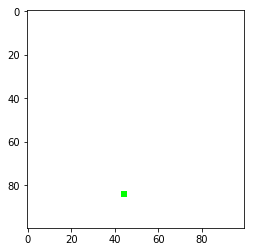

In [143]:
%matplotlib inline
#plot the result, just type in the file number -1 (since array index starts at 0) in the images[index]
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg



plt.imshow(images[130])
plt.show()